## **IMPORTS**  
<hr style="border: none; height: 3px; background: #e10600;">

**— Environment Setup & Dependencies**


In [25]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- CONFIGURATION ---
CURRENT_DIR = os.getcwd()

# Adjusting the path to reach the 'train' and 'test' folders inside the uppercase folders
if os.path.basename(CURRENT_DIR) == "PEN VS PENCIL":
    DATA_BASE = os.path.join(CURRENT_DIR, "split_dataset")
else:
    DATA_BASE = os.path.join(CURRENT_DIR, "PEN VS PENCIL", "split_dataset")

# UPDATE: Added the extra folder level ('train' and 'test') to match your directory structure
TRAIN_DIR = os.path.join(DATA_BASE, "TRAIN", "train")
TEST_DIR = os.path.join(DATA_BASE, "TEST", "test")
GRAPH_SAVE_PATH = os.path.join(DATA_BASE, "training_results.png")
                               
# --- REQUIREMENTS ---
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

# --- VERIFICATION ---
def verify_path(path_name, path_val):
    if os.path.exists(path_val):
        subfolders = [f for f in os.listdir(path_val) if os.path.isdir(os.path.join(path_val, f))]
        print(f"✅ {path_name} Found: {path_val}")
        print(f"   Classes detected: {subfolders}")
    else:
        print(f"❌ {path_name} NOT Found: {path_val}")

verify_path("TRAIN_DIR", TRAIN_DIR)
verify_path("TEST_DIR", TEST_DIR)

✅ TRAIN_DIR Found: C:\Users\LOQ\ROBOTICS\PEN VS PENCIL\split_dataset\TRAIN\train
   Classes detected: ['pen', 'pencil']
✅ TEST_DIR Found: C:\Users\LOQ\ROBOTICS\PEN VS PENCIL\split_dataset\TEST\test
   Classes detected: ['pen', 'pencil']


## **PHASE 1**  
<hr style="border: none; height: 3px; background: #e10600;">

**— Prepare Data**

In [26]:
# --- DATA GENERATORS ---

# 1. TRAIN GENERATOR (Hard Mode)
# Augmentation helps the model learn to recognize pens/pencils from different angles
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

print("Loading Training Data...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

# 2. VALIDATION GENERATOR (Easy Mode)
# We don't augment validation data; we want to test on clean images.
test_datagen = ImageDataGenerator(rescale=1./255)

print("Loading Validation Data...")
validation_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=42
)

# --- QUICK VERIFICATION ---
if train_generator.samples > 0:
    print(f"✅ Success! Found {train_generator.samples} training images.")
    print(f"Classes found: {train_generator.class_indices}")
else:
    print("❌ Error: Found 0 images. Check if your images are inside subfolders like 'train/pen' and 'train/pencil'.")

Loading Training Data...
Found 320 images belonging to 2 classes.
Loading Validation Data...
Found 80 images belonging to 2 classes.
✅ Success! Found 320 training images.
Classes found: {'pen': 0, 'pencil': 1}


## **PHASE 2**  
<hr style="border: none; height: 3px; background: #e10600;">

**— Build CNN Model**

In [27]:
model = tf.keras.models.Sequential([
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Block 2
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling2D(2, 2),

    # The Brain
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    
    tf.keras.layers.Dropout(0.3), 

    tf.keras.layers.Dense(1, activation='sigmoid')
])

## **PHASE 3**  
<hr style="border: none; height: 3px; background: #e10600;">

**— Compile and Train**

In [28]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# --- Define missing variables here ---
EPOCHS = 15  # Requirement: 10-15 Epochs
MODEL_SAVE_PATH = 'my_best_model.keras' 
# -------------------------------------

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

print(f"\nStarting Training ({EPOCHS} Epochs)...")

checkpoint = ModelCheckpoint(
    MODEL_SAVE_PATH, 
    monitor='val_accuracy', 
    save_best_only=True, 
    verbose=1
)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)


Starting Training (15 Epochs)...
Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.5131 - loss: 2.0025
Epoch 1: val_accuracy improved from None to 0.63750, saving model to my_best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5250 - loss: 1.5787 - val_accuracy: 0.6375 - val_loss: 0.6714
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.5747 - loss: 0.6586
Epoch 2: val_accuracy improved from 0.63750 to 0.83750, saving model to my_best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6187 - loss: 0.6547 - val_accuracy: 0.8375 - val_loss: 0.5732
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 0.7223 - loss: 0.5953
Epoch 3: val_accuracy did not improve from 0.83750
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 910ms/step - accuracy: 0.7000 - loss: 0.5880 - val_accuracy: 0.8375 - val_loss: 0.4419
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.7156 - loss: 0.5421
Epoch 4: val_accuracy improved from 0.8375

## **PHASE 4**  
<hr style="border: none; height: 3px; background: #e10600;">

**— Graph Results**


Training complete. Generating graphs...
Graph saved to C:\Users\LOQ\ROBOTICS\PEN VS PENCIL\split_dataset\training_results.png


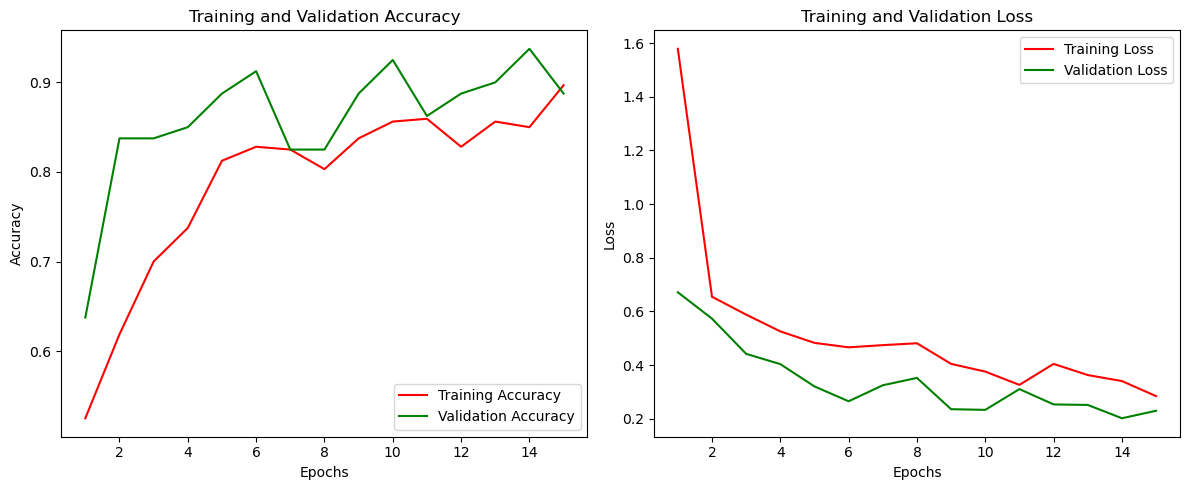

In [29]:
import matplotlib.pyplot as plt
# 5. GENERATE PLOTS
print("\nTraining complete. Generating graphs...")

acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy Subplot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss Subplot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()

# Save and Show
plt.savefig(GRAPH_SAVE_PATH, dpi = 300, bbox_inches = 'tight')
print(f"Graph saved to {GRAPH_SAVE_PATH}")
plt.show()

## **TEST MODEL INDIVIDUALLY**
<hr style="border: none; height: 3px; background: #e10600;">

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
FILE: SAMPLE.jpg
PREDICTION: PEN
CONFIDENCE: 93.92% (HIGH)
------------------------------


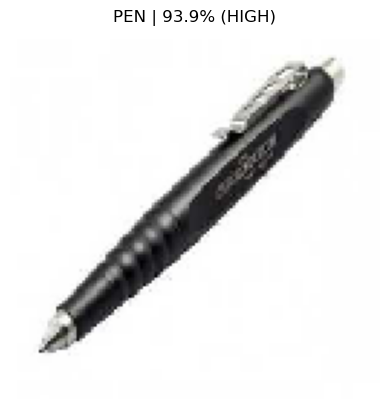

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
FILE: SAMPLE_2.jpg
PREDICTION: PENCIL
CONFIDENCE: 93.67% (HIGH)
------------------------------


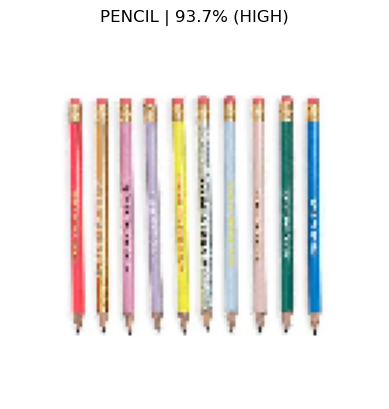

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 1. Define your list of image paths here
image_paths = [
    r"C:\Users\LOQ\ROBOTICS\PEN VS PENCIL\SAMPLE.jpg",
    r"C:\Users\LOQ\ROBOTICS\PEN VS PENCIL\SAMPLE_2.jpg" # Add your second image here
]

# 2. Set your Confidence Threshold (e.g., 80%)
THRESHOLD_LIMIT = 80.0

def predict_and_visualize(image_path):
    try:
        # Load and preprocess
        img = load_img(image_path, target_size=(128, 128))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        # Predict
        prediction = model.predict(img_array)
        score = prediction[0][0]

        # Class Mapping
        class_indices = {v: k for k, v in train_generator.class_indices.items()}
        
        if score < 0.5:
            class_name = class_indices[0].upper()
            confidence = (1 - score) * 100
        else:
            class_name = class_indices[1].upper()
            confidence = score * 100

        # Determine High vs Low Confidence
        conf_label = "HIGH" if confidence >= THRESHOLD_LIMIT else "LOW"

        # Print Results
        print(f"FILE: {image_path.split('\\')[-1]}")
        print(f"PREDICTION: {class_name}")
        print(f"CONFIDENCE: {confidence:.2f}% ({conf_label})")
        print("-" * 30)

        # Display
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{class_name} | {confidence:.1f}% ({conf_label})")
        plt.show()

    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Run the loop
for path in image_paths:
    predict_and_visualize(path)

In [41]:
from IPython.display import display, Markdown

conclusion_paragraph = """
### Project Conclusion and Reflection

When building an image classifier like this, the most common challenge is managing **data variability**, as differences in lighting, background clutter, or the angle of the pen can easily confuse a model's confidence. 
This is often compounded by **class ambiguity**, where a thin pen might look nearly identical to a pencil to a model that hasn't seen enough diverse training samples to distinguish subtle texture differences. 
Ultimately, balancing the **threshold for "high confidence"** remains a significant hurdle because a model can be mathematically "sure" of its prediction while still being incorrect if it has hyper-focused on irrelevant visual features rather than the object itself.
"""

display(Markdown(conclusion_paragraph))


### Project Conclusion and Reflection

When building an image classifier like this, the most common challenge is managing **data variability**, as differences in lighting, background clutter, or the angle of the pen can easily confuse a model's confidence. 
This is often compounded by **class ambiguity**, where a thin pen might look nearly identical to a pencil to a model that hasn't seen enough diverse training samples to distinguish subtle texture differences. 
Ultimately, balancing the **threshold for "high confidence"** remains a significant hurdle because a model can be mathematically "sure" of its prediction while still being incorrect if it has hyper-focused on irrelevant visual features rather than the object itself.
